In [230]:
from scipy.optimize import linprog
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt

# Реализация алгоритмов

In [188]:
def greedy_solve(n, K):
    m = K.shape[0]
    x = np.arange(n) + 1
    answer = np.zeros(m)
    success = True
    while x.size > 0:
        best_subset = 0
        best_size = 0
        for i in range(m):
            intersection = np.intersect1d(x, K[i])
            if intersection.size > best_size:
                best_size = intersection.size
                best_subset = i
        if best_size == 0:
            success = False
            break
        x = np.setdiff1d(x, K[best_subset])
        answer[best_subset] = 1
    return answer.astype(int) if success else None

In [189]:
def lp_solve(n, k, K):
    m = K.shape[0]
    S = np.zeros((n, m))
    for i in range(m):
        if K[i].size != 0:
            S[K[i] - 1, i] = 1
    c = np.ones((m))
    b = -np.ones((n))
    answer = linprog(c, A_ub=-S, b_ub=b, options={'cholesky': False, 'sym_pos': False, 'lstsq': True}).x >= 1 / k
    return answer.astype(int) if answer.any() else None

In [190]:
def naive_solve(n, K):
    m = K.shape[0]
    p = 2**m
    answer = np.ones(m)
    success = False
    for i in range(1, p):
        union = np.array([])
        sets = np.zeros(m)
        bits_p = bin(i)[2:].rjust(m)
        for j in range(m):
            if bits_p[j] == '1':
                union = np.union1d(union, K[j])
                sets[j] = 1
        if np.unique(union).size == n and sets.sum() <= answer.sum():
            answer = sets
            success = True
    return answer.astype(int) if success else None

In [191]:
def greedy_approximation(n, K):
    greedy_result = greedy_solve(n, K)
    naive_result = naive_solve(n, K)
    if naive_result is None:
        return None
    return greedy_result.sum() / naive_result.sum()

def lp_approximation(n, k, K):
    lp_result = lp_solve(n, k, K)
    naive_result = naive_solve(n, K)
    if naive_result is None:
        return None
    return lp_result.sum() / naive_result.sum()

# Анализ

##### "Плохой" случай для жадного алгоритма.

In [226]:
greedy_approxes = list()
lp_approxes = list()
for k in range(3, 11):
    n = 2**(k+1) - 2
    K = list()
    T0 = np.array([])
    T1 = np.array([])
    cur_elem = 1
    for i in range(k):
        S = np.arange(2**(i+1)) + cur_elem
        K.append(S)
        S_parts = np.array_split(S, 2)
        T0 = np.append(T0, S_parts[0])
        T1 = np.append(T1, S_parts[1])
        cur_elem += 2**(i+1)
    K.append(T0.astype(int))
    K.append(T1.astype(int))
    K = np.array(K)
    greedy_approxes.append(greedy_approximation(n, K))
    lp_approxes.append(lp_approximation(n, 2, K))

In [229]:
approx_data = pd.DataFrame({'k = {}'.format(k + 2): z for k, z in enumerate(zip(greedy_approxes, lp_approxes))},
                          index=['Greedy', 'LP'])
approx_data

,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 9
Greedy,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
LP,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Вывод:** Видим, что при таком выборе подмножеств результат жадного алгоритма в $\frac{\log{n}}{2}$ раз отличается от оптимального. Алгоритм же, основанный на задаче линейного программирования даёт точный результат.

##### Анализ жадного алгоритма

In [207]:
def random_greedy_test(n, m, S_size, problems_count):
    '''Возвращает массив размера problems_count, содержащий '''
    greedy_approx = np.zeros(problems_count)
    for i in range(problems_count):
        K = sps.randint(1, n + 1).rvs((m, S_size))
        missing = np.setdiff1d(np.arange(n) + 1, np.unique(K))
        if missing.size != 0:
            addition_array = np.pad(missing, (0, S_size - missing.size), 'maximum')
            K = np.append(K, [addition_array], axis=0)
        greedy_approx[i] = greedy_approximation(n, K)
    return greedy_approx

In [209]:
S_sizes = [30, 40, 50, 60, 70, 80, 90, 100]
greedy_approxes = list()
for i in S_sizes:
    greedy_approxes.append(random_greedy_test(100, 10, i, 100))

In [210]:
approx_data = pd.DataFrame({'S_size = {}'.format(i): g for i, g in zip(S_sizes, greedy_approxes)})
approx_data.describe()

,S_size = 30,S_size = 40,S_size = 50,S_size = 60,S_size = 70,S_size = 80,S_size = 90,S_size = 100
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.031417,1.051806,1.068452,1.095286,1.085095,1.101500,1.050000,1.074167
std,0.054378,0.077738,0.099053,0.112240,0.120146,0.135299,0.110478,0.145014
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.100000,1.125000,1.142857,1.200000,1.200000,1.250000,1.000000,1.000000
max,1.222222,1.285714,1.428571,1.400000,1.500000,1.500000,1.500000,1.666667


**Вывод:** Видим, что жадный алгоритм даёт достаточно хорошее приближение решения задачи о покрытии множества. В среднем отклонение от оптимального решения составляет всего 5-10%, что можно считать хорошим результатом. Однако нужно учитывать, что в некоторых случаях это отклонение может быть гораздо больше.

##### Анализ и сравнение жадного и k-приближённого алгоритма

In [231]:
def random_lp_test(n, k, problems_count):
    greedy_approx = np.zeros(problems_count)
    lp_approx = np.zeros(problems_count)
    for i in range(problems_count):
        K = np.repeat(np.arange(100) + 1, k)
        np.random.shuffle(K)
        K = K.reshape((10, 10 * k))
        greedy_approx[i] = greedy_approximation(n, K)
        lp_approx[i] = lp_approximation(n, k, K)
    return greedy_approx, lp_approx

In [232]:
greedy_approxes = list()
lp_approxes = list()
for k in range(2, 10):
    greedy, lp = random_lp_test(100, k, 100)
    greedy_approxes.append(greedy)
    lp_approxes.append(lp)

In [237]:
greedy_approx_data = pd.DataFrame({'k = {}'.format(k + 2): g for k, g in enumerate(greedy_approxes)})
greedy_approx_data.describe()

,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,1.055972,1.074762,1.052667,1.078500,1.107000,1.05250,1.036667,1.130000
std,0.063890,0.082757,0.100858,0.098795,0.123913,0.10234,0.100727,0.163402
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
75%,1.111111,1.142857,1.041667,1.200000,1.250000,1.00000,1.000000,1.333333
max,1.250000,1.333333,1.400000,1.250000,1.250000,1.25000,1.333333,1.333333


In [238]:
lp_approx_data = pd.DataFrame({'k = {}'.format(k + 2): l for k, l in enumerate(lp_approxes)})
lp_approx_data.describe()

,k = 2,k = 3,k = 4,k = 5,k = 6,k = 7,k = 8,k = 9
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
mean,1.056111,1.430595,1.583952,1.85100,2.080000,2.272500,2.388333,2.800000
std,0.075350,0.090222,0.160816,0.18708,0.307811,0.216419,0.307094,0.436321
min,1.000000,1.000000,1.333333,1.40000,1.400000,1.500000,1.750000,1.750000
25%,1.000000,1.428571,1.500000,1.80000,1.800000,2.250000,2.250000,2.500000
50%,1.000000,1.428571,1.633333,1.80000,2.000000,2.250000,2.250000,3.000000
75%,1.111111,1.428571,1.666667,2.00000,2.250000,2.500000,2.500000,3.083333
max,1.250000,1.666667,2.000000,2.25000,2.500000,2.500000,3.333333,3.333333


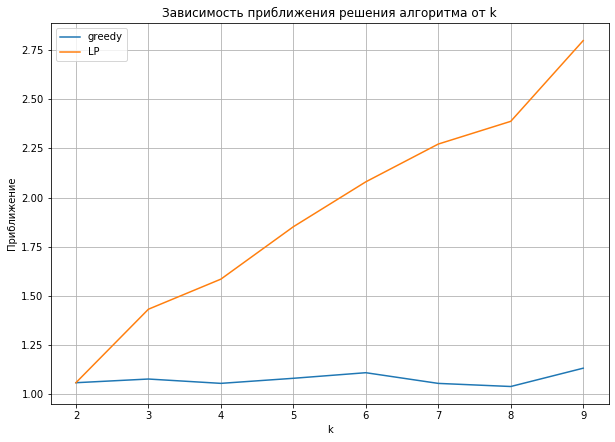

In [240]:
k = np.arange(8) + 2

plt.figure(figsize=(10, 7))
plt.plot(k, greedy_approx_data.mean(), label='greedy')
plt.plot(k, lp_approx_data.mean(), label='LP')
plt.title('Зависимость приближения решения алгоритма от k')
plt.xlabel('k')
plt.ylabel('Приближение')
plt.grid()
plt.legend()
plt.show()

**Вывод:** Таким образом, если подмножества имеют одинаковый размер, а каждый элемент встречается ровно в k подмножествах, то в среднем случае жадный алгоритм даёт лучшее приближение, чем алгоритм, опирающийся на линейное программирование. Причём можно даже видеть, что с ростом k отличие результата вторго алгоритма от оптимального растёт, а для жадного алгоритма это отличие вообще не зависит от k.